In [739]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns

## Scraping

In [740]:
# Functions to scrape tables from wikipedia websites for the golf tournament scorecards

def crawl(page_url, api_token=None):
    try:
        response = requests.get(page_url)
        if response.status_code == 200:
            print("200 response")
            return scrape_data(response.text)
        else:
            print(f"Error: {response.status_code}")
            return None
    except Exception as e:
        print(f"An error occurred during crawling: {e}")
        return None

def scrape_data(html_content):
    # Use Beautiful Soup and check for / grab each table
    try:
        soup = BeautifulSoup(html_content, 'html.parser')
        tables = soup.select('.wikitable')

        if not tables:
            print("No wikitable found.")
            return None

        for index, table in enumerate(tables):
            try:
                df = pd.read_html(StringIO(str(table)))[0]

                # Check if there's a row labeled "Par"
                par_row = None
                for i in range(len(df)):
                    row = df.iloc[i]
                    if str(row.iloc[0]).strip().lower() == "par":
                        par_row = row
                        break

                if par_row is not None:
                    numeric_values = pd.to_numeric(par_row[1:], errors='coerce')
                    if numeric_values.notna().sum() == 18:  # Check for 18 holes
                        #print(f"Scorecard likely found at table index {index}")
                        # Check if the tables has at least 5 rows
                        if len(df) >= 5:
                            return df
                        else:
                            continue
            # Handle potential errors
            except Exception as inner_e:
                print(f"Skipping table {index}: {inner_e}")
                continue

        print("No scorecard-like table found.")
        return None
    # More error handling
    except Exception as e:
        print(f"An error occurred during data extraction: {e}")
        return None


In [741]:
# Individual usage example
url = 'https://en.wikipedia.org/wiki/2025_Masters_Tournament'
html = requests.get(url).text
scorecard_df = scrape_data(html_content=html)


In [742]:
# URL slugs for each tournament
slugs = {
    "masters": "_Masters_Tournament",
    "pga": "_PGA_Championship",
    "usopen": "_U.S._Open_(golf)",
    "open": "_Open_Championship"
}

# List of playoff years for each tournament (since 2000)
tournaments = {
    "masters": [2003, 2005, 2009, 2012, 2013, 2017, 2025],
    "pga": [2000, 2004, 2010, 2011, 2022],
    "usopen": [2001, 2008],
    "open": [2002, 2004, 2007, 2009, 2015]
}


base_url = "https://en.wikipedia.org/wiki/"
scorecards = {}

# Create dataframe for each year/tournament desired
# Add dataframe to scorecards dictionary
for major in tournaments:
    for year in tournaments[major]:
        url = base_url + str(year) + slugs[major]
        html = requests.get(url).text
        scorecard_df = scrape_data(html_content=html)
        key = f"{year}_{major}"
        if scorecard_df is not None:
            scorecards[key] = scorecard_df

In [743]:
for key, df in scorecards.items():

# Replace unicode minus with hyphen-minus
    for col in df.columns[1:]:
        df[col] = df[col].astype(str).str.replace('−', '-', regex=False)

# Replace even scores (E) with 0
    for row in df.index:
        for col in df.columns:
            if df.at[row, col] == 'E':
                df.at[row, col] = 0

# Convert all score count cells to numeric
    df[df.columns[1:]] = df[df.columns[1:]].apply(pd.to_numeric, errors='coerce')

In [744]:
scorecards["2005_masters"]

,Hole,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,Par,4,5,4,3,4,3,4,5,4,4,4,3,5,4,5,3,4,4
1,Woods,-12,-13,-13,-13,-12,-12,-12,-12,-13,-12,-12,-12,-12,-12,-13,-14,-13,-12
2,DiMarco,-8,-9,-9,-9,-9,-9,-9,-9,-10,-10,-11,-10,-10,-11,-12,-12,-12,-12
3,Donald,-2,-2,-2,-2,-2,-2,-1,-1,-1,1,0,0,-2,-2,-4,-5,-5,-5
4,Goosen,-1,-2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-2,-2,-3,-4,-4,-5
5,Hensby,-4,-4,-4,-4,-4,-4,-4,-5,-5,-4,-2,-3,-3,-3,-4,-5,-5,-4
6,Immelman,-4,-4,-4,-4,-5,-6,-6,-6,-6,-6,-5,-5,-3,-3,-3,-5,-4,-4
7,Pampling,-2,-2,-1,-2,-2,-2,-1,-1,-2,-2,-2,-2,-2,-3,-4,-4,-4,-4
8,Singh,-4,-4,-3,-2,-1,-2,-2,-3,-3,-3,-3,-3,-3,-3,-3,-3,-3,-4
9,Weir,-3,-4,-4,-4,-4,-5,-5,-5,-5,-6,-6,-6,-6,-6,-7,-6,-5,-4


## Dataframe Calculations & Setting

In [745]:
# Only keep players from the playoffs
for key, df in scorecards.items():
    lowestScore = 100
    for score in df['18']:
        if score < lowestScore:
            lowestScore = score
    scorecards[key] = df[df['18'] == lowestScore]

In [746]:
scorecards["2017_masters"]

,Hole,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
1,García,-7,-7,-8,-8,-8,-8,-8,-8,-8,-7,-6,-6,-6,-7,-9,-9,-9,-9
2,Rose,-6,-6,-6,-6,-5,-6,-7,-8,-8,-8,-8,-8,-8,-8,-9,-10,-9,-9


In [747]:
# Create main dataframe

# _x_MScore stands for the golfer's Momentum Score; This represents their score over the last _x_ number of holes
# The MScore avg's represent the average of that tournament and year relative to their competitors in the playoff


playoffs = pd.DataFrame(columns=[
    'Tournament', 'Year', 'Winner',
    '18MScore Avg', '5MScore Avg', '3MScore Avg', '1MScore Avg',
    'Player 1', 'p1 18MScore', 'p1 5MScore', 'p1 3MScore', 'p1 1MScore',
    'Player 2', 'p2 18MScore', 'p2 5MScore', 'p2 3MScore', 'p2 1MScore',
    'Player 3', 'p3 18MScore', 'p3 5MScore', 'p3 3MScore', 'p3 1MScore',
    'Player 4', 'p4 18MScore', 'p4 5MScore', 'p4 3MScore', 'p4 1MScore',
])

In [748]:
def extract_scores(key, df):
    # Seperate tournament names and year
    # Seperate players from scores
    year, tournament = key.split('_')
    players = df.iloc[:, 0].tolist()
    scores = df.iloc[:, 1:].astype(float)
    
    final_cols = {
        'Tournament': tournament,
        'Year': int(year),
        'Winner': players[0] if players else None
    }

    last_18_total = 0
    last_5_total = 0
    last_3_total = 0
    last_1_total = 0

    # Loop through 4 potential players
    for i in range(4):
        if i < len(players):
            name = players[i]

            # Calculate momentum scores
            final_score = scores.iloc[i, -1]
            last_18 = final_score - scores.iloc[i, 0]
            last_5 = final_score - scores.iloc[i, -6]
            last_3 = final_score - scores.iloc[i, -4]
            last_1 = final_score - scores.iloc[i, -2]

            # Calculates total momentum score for all players
            last_18_total += last_18
            last_5_total += last_5
            last_3_total += last_3
            last_1_total += last_1

            # Add scores to dictionary
            final_cols[f'Player {i+1}'] = name
            final_cols[f'p{i+1} 18MScore'] = last_18
            final_cols[f'p{i+1} 5MScore'] = last_5
            final_cols[f'p{i+1} 3MScore'] = last_3
            final_cols[f'p{i+1} 1MScore'] = last_1

        else:
            # None value for empty player slots
            final_cols[f'Player {i+1}'] = None
            final_cols[f'p{i+1} 18MScore'] = None
            final_cols[f'p{i+1} 5MScore'] = None
            final_cols[f'p{i+1} 3MScore'] = None
            final_cols[f'p{i+1} 1MScore'] = None

        # Grab number of players in row (filters out null or empty strings)
        num_players = len([p for p in players if p])

        # Calculate average momentum scores and add to dicitonary (rounded to two places)
        if num_players > 0:
            final_cols['18MScore Avg'] = round(last_18_total / num_players, 2)
            final_cols['5MScore Avg'] = round(last_5_total / num_players, 2)
            final_cols['3MScore Avg'] = round(last_3_total / num_players, 2)
            final_cols['1MScore Avg'] = round(last_1_total / num_players, 2)
        else:
            final_cols['18MScore Avg'] = None
            final_cols['5MScore Avg'] = None
            final_cols['3MScore Avg'] = None
            final_cols['1MScore Avg'] = None


    return final_cols

# Apply to each scorecard
for key, df in scorecards.items():
    row = extract_scores(key, df)
    playoffs = pd.concat([playoffs, pd.DataFrame([row])], ignore_index=True)

C:\Users\benne\AppData\Local\Temp\ipykernel_12020\2239507949.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  playoffs = pd.concat([playoffs, pd.DataFrame([row])], ignore_index=True)
C:\Users\benne\AppData\Local\Temp\ipykernel_12020\2239507949.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  playoffs = pd.concat([playoffs, pd.DataFrame([row])], ignore_index=True)
C:\Users\benne\AppData\Local\Temp\ipykernel_12020\2239507949.py:73: FutureWarning: The behavior of DataFrame concatenation wit

In [749]:
pd.set_option('display.max_columns', None)
playoffs

,Tournament,Year,Winner,18MScore Avg,5MScore Avg,3MScore Avg,1MScore Avg,Player 1,p1 18MScore,p1 5MScore,p1 3MScore,p1 1MScore,Player 2,p2 18MScore,p2 5MScore,p2 3MScore,p2 1MScore,Player 3,p3 18MScore,p3 5MScore,p3 3MScore,p3 1MScore,Player 4,p4 18MScore,p4 5MScore,p4 3MScore,p4 1MScore
0,masters,2003,Weir,-5.50,-1.0,0.0,0.50,Weir,-4.0,-1.0,0.0,0.0,Mattiace,-7.0,-1.0,0.0,1.0,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
1,masters,2005,Woods,-2.00,-1.0,0.5,0.50,Woods,0.0,0.0,1.0,1.0,DiMarco,-4.0,-2.0,0.0,0.0,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
2,masters,2009,Cabrera,-1.67,-1.0,0.0,0.33,Cabrera,-1.0,-2.0,-1.0,0.0,Perry,-1.0,0.0,1.0,1.0,Campbell,-3.0,-1.0,0.0,0.0,None,NaN,NaN,NaN,NaN
3,masters,2012,Watson,-4.00,-2.0,-0.5,0.00,Watson,-5.0,-3.0,-1.0,0.0,Oosthuizen,-3.0,-1.0,0.0,0.0,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
4,masters,2013,Scott,-3.00,-2.0,-1.5,-1.00,Scott,-4.0,-2.0,-1.0,-1.0,Cabrera,-2.0,-2.0,-2.0,-1.0,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
5,masters,2017,García,-2.50,-2.0,0.0,0.00,García,-2.0,-3.0,0.0,0.0,Rose,-3.0,-1.0,0.0,0.0,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
6,masters,2025,McIlroy,-3.00,-0.5,-0.5,0.00,McIlroy,-1.0,0.0,0.0,1.0,Rose,-5.0,-1.0,-1.0,-1.0,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
7,pga,2000,Woods,-5.50,-2.5,-1.5,-1.00,Woods,-5.0,-3.0,-2.0,-1.0,May,-6.0,-2.0,-1.0,-1.0,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
8,pga,2004,Singh,2.00,2.0,1.0,0.33,Singh,4.0,1.0,0.0,0.0,DiMarco,-1.0,2.0,1.0,0.0,Leonard,3.0,3.0,2.0,1.0,None,NaN,NaN,NaN,NaN
9,pga,2010,Kaymer,-3.00,0.0,0.0,0.00,Kaymer,-2.0,1.0,0.0,0.0,Watson,-4.0,-1.0,0.0,0.0,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN


In [750]:
# Creating new dataframe for ease of data analysis
# Each row now represents an individual player rather than the tournament

# The MScore avg's again represent the average of that tournament and year relative to their competitors in the playoff

playoff_players = pd.DataFrame(columns= ['Tournament', 'Year', 'Name', 'Winner', '18MScore', '5MScore', '3MScore', '1MScore', '18MScore Avg', '5MScore Avg', '3MScore Avg', '1MScore Avg'])

for _, row in playoffs.iterrows():
    for i in range(1,5):
        name = row.get(f'Player {i}')
        if pd.notna(name):
            playoff_players.loc[len(playoff_players)] = {
                'Name': name,
                'Tournament': row.get('Tournament'),
                'Year': row.get('Year'),
                'Winner': 'Yes' if name == row['Winner'] else 'No',
                '18MScore': row.get(f'p{i} 18MScore'),
                '5MScore': row.get(f'p{i} 5MScore'),
                '3MScore': row.get(f'p{i} 3MScore'),
                '1MScore': row.get(f'p{i} 1MScore'),
                '18MScore Avg': row.get('18MScore Avg'),
                '5MScore Avg': row.get('5MScore Avg'),
                '3MScore Avg': row.get('3MScore Avg'),
                '1MScore Avg': row.get('1MScore Avg'),
                }

## Visualizations

#### Bar Plots

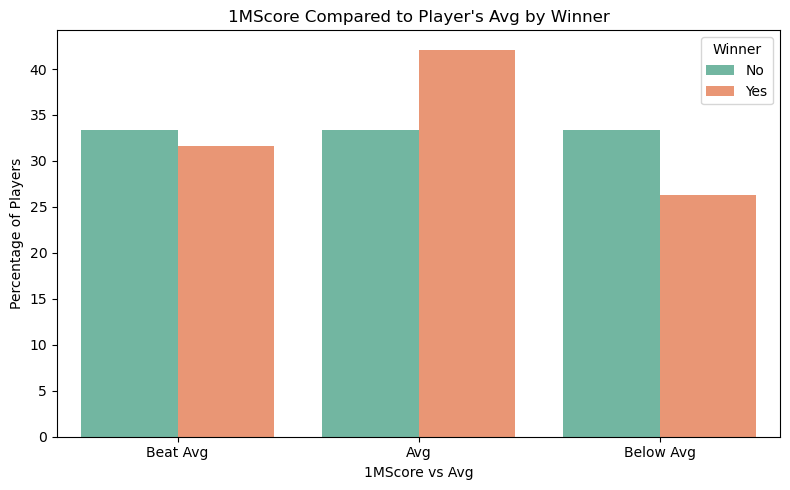

In [ ]:
def compare_to_avg(row):
    avg = row["1MScore Avg"]
    score = row["1MScore"]
    if pd.isna(score) or pd.isna(avg):
        return None
    if score < avg:
        return "Beat Avg"
    elif score > avg:
        return "Below Avg"
    else:
        return "Avg"

# Apply compare_to_avg
playoff_players["1MScore vs Avg"] = playoff_players.apply(compare_to_avg, axis=1)

# Count players in each category (Win/Loss & Beat/Avg/Below)
counts = playoff_players.groupby(["Winner", "1MScore vs Avg"]).size().reset_index(name="Count")
# Calculate total counts & convert to percentages
total_per_winner = counts.groupby("Winner")["Count"].transform("sum")
counts["Percent"] = counts["Count"] / total_per_winner * 100

order = ["Beat Avg", "Avg", "Below Avg"]

plt.figure(figsize=(8, 5))
sns.barplot(data=counts, x="1MScore vs Avg", y="Percent", hue="Winner", order=order, palette="Set2")
plt.title("1MScore Compared to Player's Avg by Winner")
plt.xlabel("1MScore vs Avg")
plt.ylabel("Percentage of Players")
plt.legend(title="Winner")
plt.tight_layout()
plt.show()


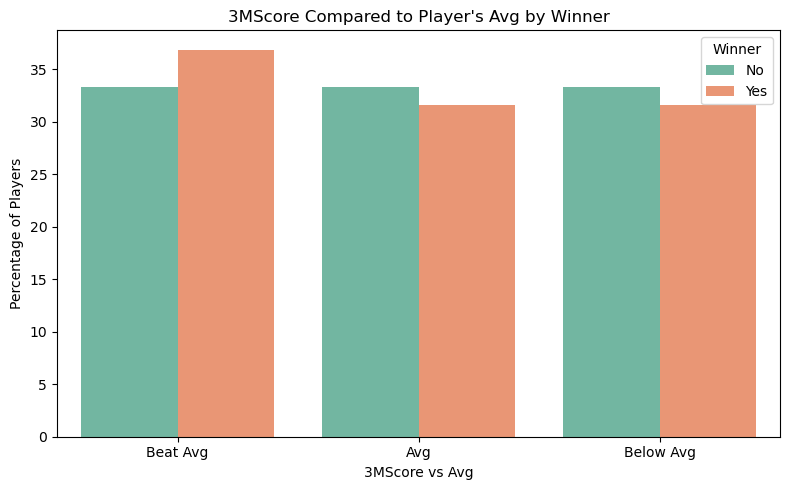

In [ ]:
def compare_to_avg(row):
    avg = row["3MScore Avg"]
    score = row["3MScore"]
    if pd.isna(score) or pd.isna(avg):
        return None
    if score < avg:
        return "Beat Avg"
    elif score > avg:
        return "Below Avg"
    else:
        return "Avg"

# Apply compare_to_avg
playoff_players["3MScore vs Avg"] = playoff_players.apply(compare_to_avg, axis=1)

# Count players in each category (Win/Loss & Beat/Avg/Below)
counts = playoff_players.groupby(["Winner", "3MScore vs Avg"]).size().reset_index(name="Count")
# Calculate total counts & convert to percentages
total_per_winner = counts.groupby("Winner")["Count"].transform("sum")
counts["Percent"] = counts["Count"] / total_per_winner * 100

order = ["Beat Avg", "Avg", "Below Avg"]

plt.figure(figsize=(8, 5))
sns.barplot(data=counts, x="3MScore vs Avg", y="Percent", hue="Winner", order=order, palette="Set2")
plt.title("3MScore Compared to Player's Avg by Winner")
plt.xlabel("3MScore vs Avg")
plt.ylabel("Percentage of Players")
plt.legend(title="Winner")
plt.tight_layout()
plt.show()


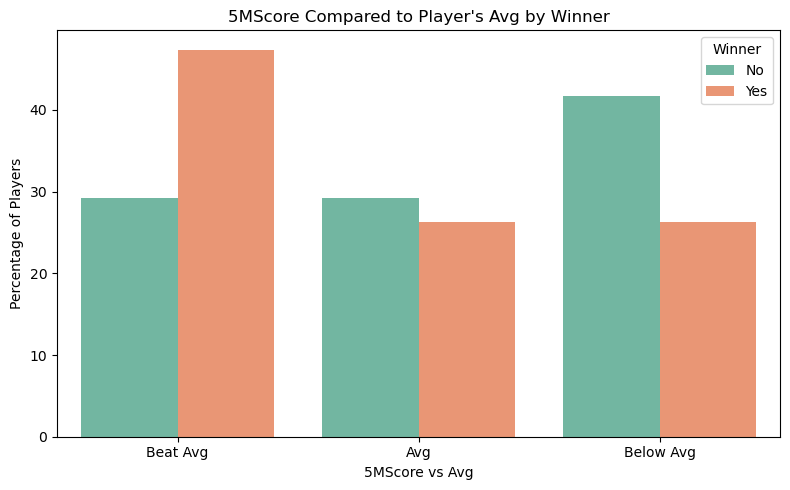

In [ ]:
def compare_to_avg(row):
    avg = row["5MScore Avg"]
    score = row["5MScore"]
    if pd.isna(score) or pd.isna(avg):
        return None
    if score < avg:
        return "Beat Avg"
    elif score > avg:
        return "Below Avg"
    else:
        return "Avg"

# Apply compare_to_avg
playoff_players["5MScore vs Avg"] = playoff_players.apply(compare_to_avg, axis=1)

# Count players in each category (Win/Loss & Beat/Avg/Below)
counts = playoff_players.groupby(["Winner", "5MScore vs Avg"]).size().reset_index(name="Count")
# Calculate total counts & convert to percentages
total_per_winner = counts.groupby("Winner")["Count"].transform("sum")
counts["Percent"] = counts["Count"] / total_per_winner * 100

order = ["Beat Avg", "Avg", "Below Avg"]

plt.figure(figsize=(8, 5))
sns.barplot(data=counts, x="5MScore vs Avg", y="Percent", hue="Winner", order=order, palette="Set2")
plt.title("5MScore Compared to Player's Avg by Winner")
plt.xlabel("5MScore vs Avg")
plt.ylabel("Percentage of Players")
plt.legend(title="Winner")
plt.tight_layout()
plt.show()


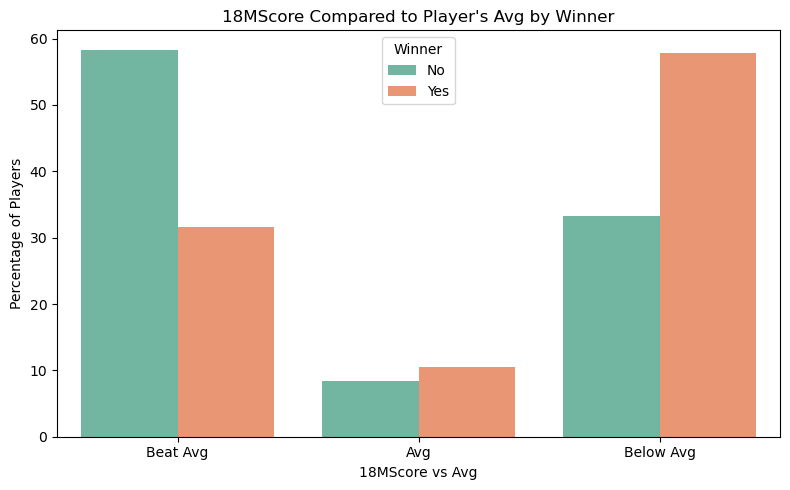

In [ ]:
def compare_to_avg(row):
    avg = row["18MScore Avg"]
    score = row["18MScore"]
    if pd.isna(score) or pd.isna(avg):
        return None
    if score < avg:
        return "Beat Avg"
    elif score > avg:
        return "Below Avg"
    else:
        return "Avg"

# Apply compare_to_avg
playoff_players["18MScore vs Avg"] = playoff_players.apply(compare_to_avg, axis=1)

# Count players in each category (Win/Loss & Beat/Avg/Below)
counts = playoff_players.groupby(["Winner", "18MScore vs Avg"]).size().reset_index(name="Count")
# Calculate total counts & convert to percentages
total_per_winner = counts.groupby("Winner")["Count"].transform("sum")
counts["Percent"] = counts["Count"] / total_per_winner * 100

order = ["Beat Avg", "Avg", "Below Avg"]

plt.figure(figsize=(8, 5))
sns.barplot(data=counts, x="18MScore vs Avg", y="Percent", hue="Winner", order=order, palette="Set2")
plt.title("18MScore Compared to Player's Avg by Winner")
plt.xlabel("18MScore vs Avg")
plt.ylabel("Percentage of Players")
plt.legend(title="Winner")
plt.tight_layout()
plt.show()


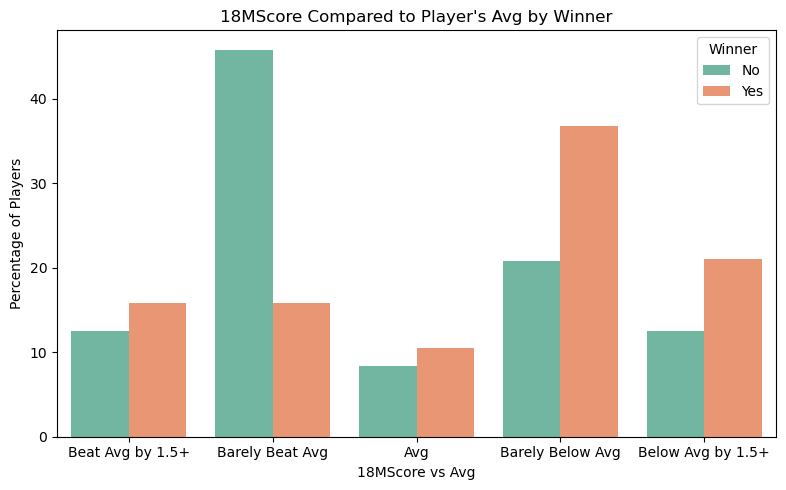

In [ ]:
# 18MScore comparison but with more categories

def compare_to_avg(row):
    avg = row["18MScore Avg"]
    score = row["18MScore"]
    if pd.isna(score) or pd.isna(avg):
        return None
    if score < avg - 1.5:
        return "Beat Avg by 1.5+"
    elif score < avg:
        return "Barely Beat Avg"
    elif score > avg + 1.5:
        return "Below Avg by 1.5+"
    elif score > avg:
        return "Barely Below Avg"
    else:
        return "Avg"

# Apply compare_to_avg
playoff_players["18MScore vs Avg"] = playoff_players.apply(compare_to_avg, axis=1)

# Count players in each category (Win/Loss & Beat+/Beat/Avg/Below/Below+)
counts = playoff_players.groupby(["Winner", "18MScore vs Avg"]).size().reset_index(name="Count")
# Calculate total counts & convert to percentages
total_per_winner = counts.groupby("Winner")["Count"].transform("sum")
counts["Percent"] = counts["Count"] / total_per_winner * 100

order = ["Beat Avg by 1.5+", "Barely Beat Avg", "Avg", "Barely Below Avg", "Below Avg by 1.5+"]

plt.figure(figsize=(8, 5))
sns.barplot(data=counts, x="18MScore vs Avg", y="Percent", hue="Winner", order=order, palette="Set2")
plt.title("18MScore Compared to Player's Avg by Winner")
plt.xlabel("18MScore vs Avg")
plt.ylabel("Percentage of Players")
plt.legend(title="Winner")
plt.tight_layout()
plt.show()

#### Boxplots

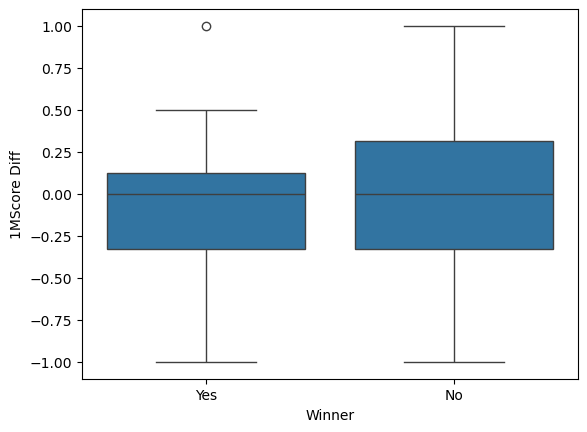

In [ ]:
# Boxplot of 1MScore Differential for playoff winners and losers
playoff_players["1MScore Diff"] = playoff_players["1MScore"] - playoff_players["1MScore Avg"]
ax = sns.boxplot(x="Winner", y="1MScore Diff", data=playoff_players)

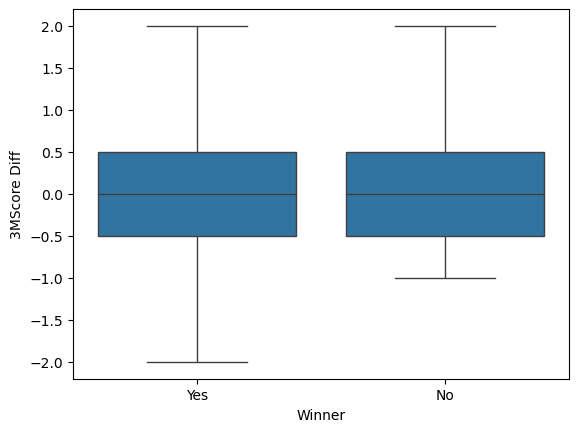

In [ ]:
# Boxplot of 3MScore Differential for playoff winners and losers
playoff_players["3MScore Diff"] = playoff_players["3MScore"] - playoff_players["3MScore Avg"]
ax = sns.boxplot(x="Winner", y="3MScore Diff", data=playoff_players)

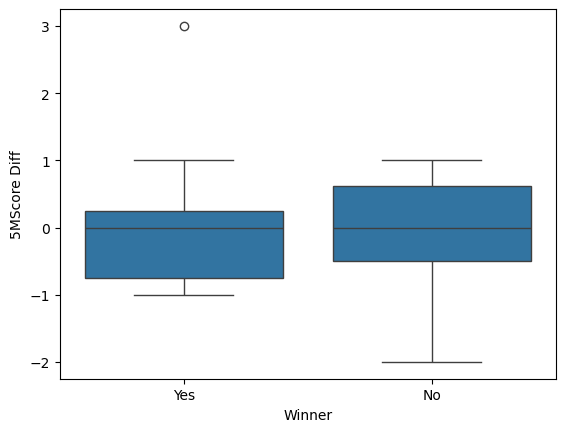

In [ ]:
# Boxplot of 5MScore Differential for playoff winners and losers
playoff_players["5MScore Diff"] = playoff_players["5MScore"] - playoff_players["5MScore Avg"]
ax = sns.boxplot(x="Winner", y="5MScore Diff", data=playoff_players)

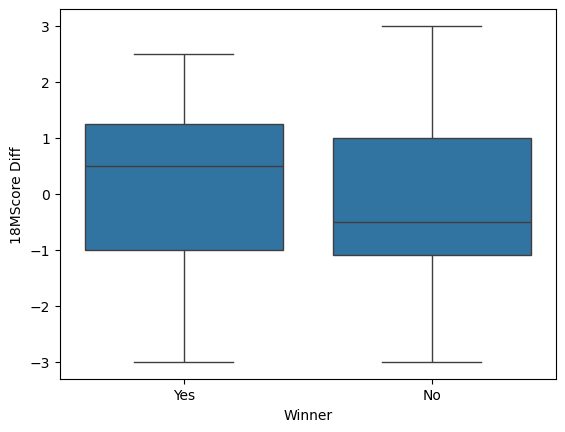

In [ ]:
# Boxplot of 18MScore Differential for playoff winners and losers
playoff_players["18MScore Diff"] = playoff_players["18MScore"] - playoff_players["18MScore Avg"]
ax = sns.boxplot(x="Winner", y="18MScore Diff", data=playoff_players)

#### Decision Tree

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# Calculate difference of golfer's xMScore & the xMScore average
playoff_players["18MScore Diff"] = playoff_players["18MScore"] - playoff_players["18MScore Avg"]
playoff_players["5MScore Diff"] = playoff_players["5MScore"] - playoff_players["5MScore Avg"]
playoff_players["3MScore Diff"] = playoff_players["3MScore"] - playoff_players["3MScore Avg"]
playoff_players["1MScore Diff"] = playoff_players["1MScore"] - playoff_players["1MScore Avg"]

In [793]:
X=playoff_players[['1MScore Diff', '3MScore Diff', '5MScore Diff', '18MScore Diff']]
y = playoff_players['Winner']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=168)

# Create a decision tree classifier
dtree = DecisionTreeClassifier(random_state=168)

# Train the classifier
dtree.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dtree.predict(X_test)

In [794]:
dt_pre_pruned = DecisionTreeClassifier(max_depth=2, min_samples_split=4, min_samples_leaf=2)

# Train the model
dt_pre_pruned.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=2, min_samples_split=4)

[Text(0.5, 0.8333333333333334, '18MScore Diff <= -0.25\ngini = 0.498\nsamples = 34\nvalue = [18, 16]\nclass = No'),
 Text(0.25, 0.5, '18MScore Diff <= -0.835\ngini = 0.43\nsamples = 16\nvalue = [11, 5]\nclass = No'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'gini = 0.5\nsamples = 10\nvalue = [5, 5]\nclass = No'),
 Text(0.375, 0.16666666666666666, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]\nclass = No'),
 Text(0.75, 0.5, '5MScore Diff <= 0.25\ngini = 0.475\nsamples = 18\nvalue = [7, 11]\nclass = Yes'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'gini = 0.219\nsamples = 8\nvalue = [1, 7]\nclass = Yes'),
 Text(0.875, 0.16666666666666666, 'gini = 0.48\nsamples = 10\nvalue = [6, 4]\nclass = No')]

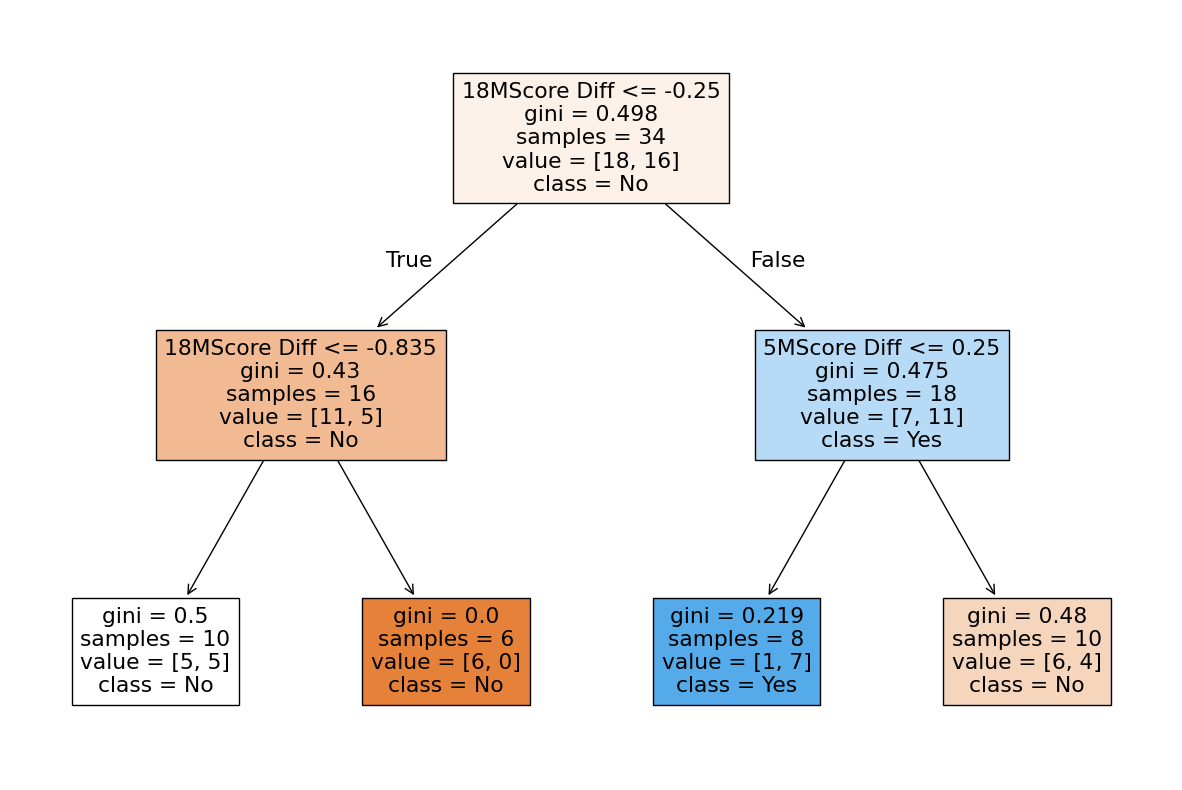

In [795]:
fig = plt.figure(figsize=(15,10))
tree.plot_tree(dt_pre_pruned,
                   feature_names=['1MScore Diff', '3MScore Diff', '5MScore Diff', '18MScore Diff'],
                   class_names=['No','Yes'],
                   filled=True)